####################################################################################################
####################################################################################################

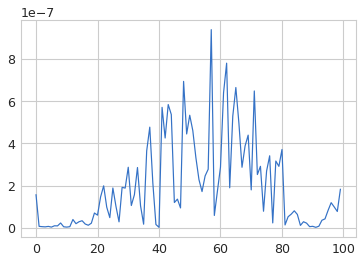

In [27]:
import numpy as np

import openqcs as oqcs
import openqcs.tools as tools
import openqcs.spinchain as sp
from openqcs.qcirc import su2_to_circuit
from openqcs.statistic import bootstrap
from scipy.optimize import minimize
import pyqcs

import matplotlib.pyplot as plt


def cost(param, rho0, rho):
    p = np.cos(param[0])**2
    S0 = tools.su2(param[1:4])
    S1 = tools.su2(param[4:])
    
    rhop = p * S0@rho0@S0.H + (1-p)*S1@rho0@S1.H
    return np.linalg.norm(rhop - rho)

def get_param(rho, rho0, param0):
    
    err = 100000
    
    for i in range(5):
        param0 = np.random.rand(7)
        sol = minimize(cost, param0, args=(rho0, rho))
        if sol.fun < err:
            err = sol.fun
            param = sol.x
    
    return param, err

def measure_ensemble_1qubit(param, iSt, n_sample=100, n_measure=1000):
    p = np.cos(param[0])**2
    
    circs = [su2_to_circuit(0, param[1+i*3:1+(i+1)*3]) for i in range(2)]
    
    M_data = np.zeros((n_sample, 2), dtype=np.double)
    
    for k in range(n_sample):
        # draw random number
        q = np.random.rand()
        if q < p:
            psi = circs[0] * iSt
        else:
            psi = circs[1] * iSt
        
        res = pyqcs.sample(psi, 1, n_measure)
        
        for key, val in res.items():
            M_data[k, key] = np.double(val)/n_measure
            
    mean0, err0 = bootstrap(M_data[:,0])
    mean1, err1 = bootstrap(M_data[:,1])
    
    return np.array([[mean0, err0], [mean1, err1]])
            

def evolution(T, n_t=100):
    
    iSt = pyqcs.State.new_zero_state(1)
    
    errs = np.zeros((n_t,),dtype=np.double)
    data = np.zeros((n_t,2,2),dtype=np.double)
    
    rho0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    param = np.random.rand(7)
    
    print("#"*100)
    for i in range(n_t):
        print("#", end="", flush=True)
        Ks = oqcs.get_kraus_(T**(i+1))
        rho = oqcs.channel_(rho0, Ks)
        
        param, err = get_param(rho, rho0, param)
        
        errs[i] = err
        data[i,:,:] = measure_ensemble_1qubit(param, iSt)
        
    return data, errs

a = 0.5
b = 0.5
dt = 0.05

H = sp.H_(a,b)
T = sp.T_(H,dt)

data, errs = evolution(T)

plt.figure()
plt.plot(errs)
plt.show()
        
        
        



In [32]:
def classical_evo(T,n_t=100):
    rho0 = np.matrix([[1,0],[0,0]], dtype=np.complex)
    
    Data = np.zeros((n_t,2), dtype=np.double)
    for n in range(n_t):
        Ks = oqcs.get_kraus_(T**(n+1))
        rho = oqcs.channel_(rho0, Ks)
            
        Data[n,:] = [rho[0,0].real, rho[1,1].real]
        
    return Data

Data_cl = classical_evo(T)


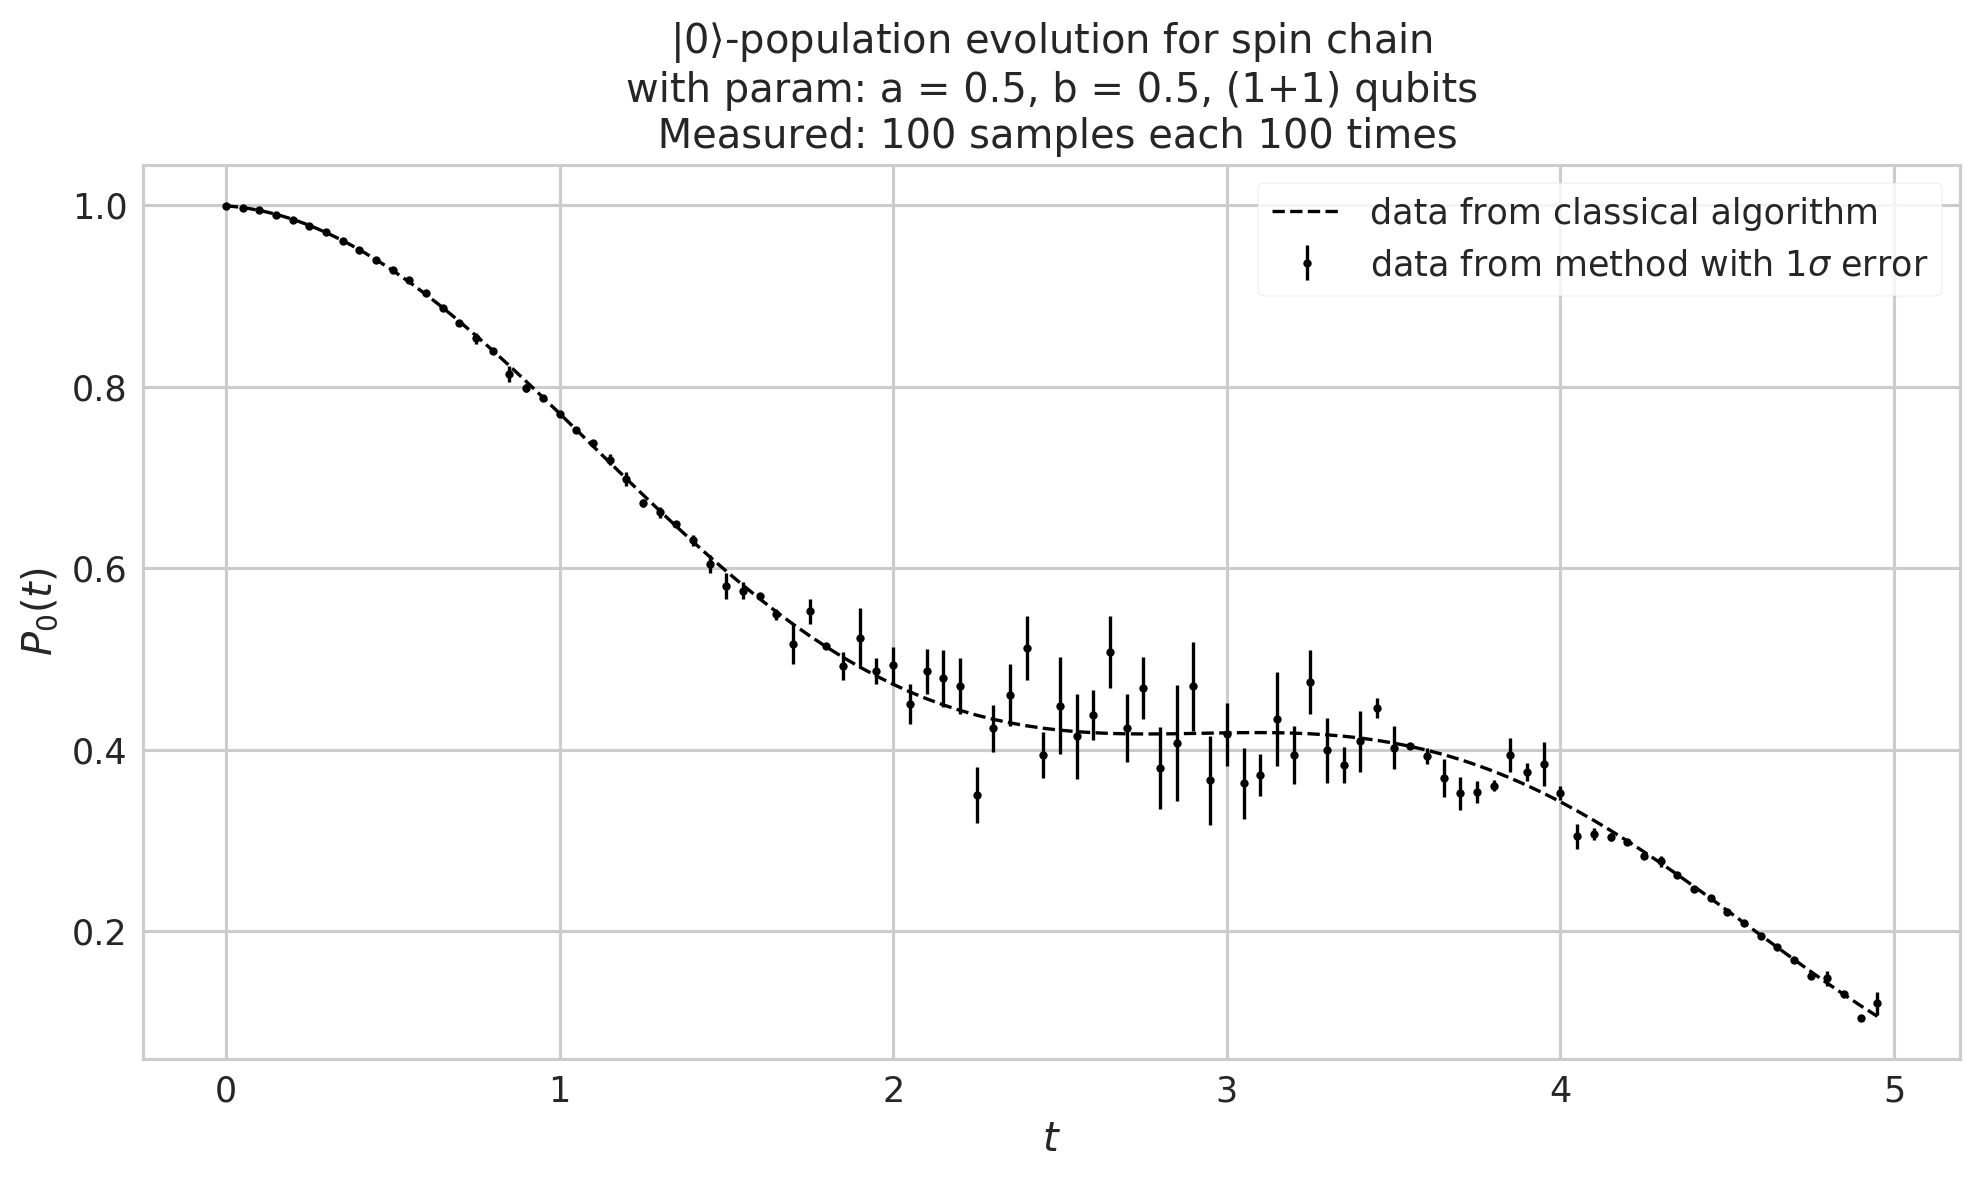

In [62]:
time_ = np.arange(Data_cl.shape[0])*dt
plt.figure(figsize=(10,6),dpi=200)
plt.errorbar(time_, data[:,0,0], yerr=data[:,0,1], fmt="o", markersize=3, color="black", 
             label="data from method with "+r"$1\sigma$"+" error")
plt.plot(time_, Data_cl[:,0], linestyle="--", color="black", label="data from classical algorithm")
plt.ylabel("$P_0(t)$")
plt.xlabel("$t$")
plt.legend()
plt.title(r"$\vert 0 \rangle$"+"-population evolution for spin chain\n"+
    "with param: a = 0.5, b = 0.5, (1+1) qubits\n Measured: 100 samples each 100 times")
plt.tight_layout()
plt.savefig("minimizer_method.png", format="png")
plt.show()